<a href="https://colab.research.google.com/github/nickchai-457/Week3Lab/blob/main/XGBOOTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
!pip install ace_tools


# Necessary imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
try:
    import ace_tools as tools
except ModuleNotFoundError:
    print("The 'ace_tools' module is not installed. Please install it using pip:")
    print("!pip install ace_tools")
    # Provide a fallback to display the data if ace_tools is not available
    def display_dataframe_to_user(name, dataframe):
        print(f"--- {name} ---")
        print(dataframe.head())
        print(f"--- End of {name} ---")
    tools = type('', (), {'display_dataframe_to_user': display_dataframe_to_user})  # Create a dummy module
    # Provide a fallback to display the data if ace_tools is not available
    def display_dataframe_to_user(name, dataframe):
        print(f"--- {name} ---")
        print(dataframe.head())
        print(f"--- End of {name} ---")
    tools = type('', (), {'display_dataframe_to_user': display_dataframe_to_user})  # Create a dummy module

The 'ace_tools' module is not installed. Please install it using pip:
!pip install ace_tools


# 新段落

In [ ]:
# Step 1: Load the datasets
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')

# Step 2: Convert time columns to datetime
# For columns with mixed time zones, convert them to UTC first
energy_df['time'] = pd.to_datetime(energy_df['time'], errors='coerce', utc=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], errors='coerce', utc=True)

# Remove any timezone information after conversion
energy_df['time'] = energy_df['time'].dt.tz_localize(None)
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_localize(None)

# Step 3: Merge the datasets on time
merged_df = pd.merge(energy_df, weather_df, left_on='time', right_on='dt_iso', how='inner')

# Step 4: Drop redundant columns
merged_df.drop(columns=['dt_iso', 'city_name'], inplace=True)

# Step 5: Handle missing values
merged_df.fillna(method='ffill', inplace=True)

# Step 6: Feature Engineering - Extract time-based features
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['year'] = merged_df['time'].dt.year

# Step 7: Cluster cities based on weather patterns (KMeans) - Updated with 5 clusters
weather_features = merged_df[['temp', 'wind_speed', 'humidity', 'pressure','clouds_all']]
scaler = StandardScaler()
weather_features_scaled = scaler.fit_transform(weather_features)

kmeans = KMeans(n_clusters=5, random_state=42)
merged_df['weather_cluster'] = kmeans.fit_predict(weather_features_scaled)

# Step 8: Select relevant features for XGBoost
XGBOOST_features = [
    'time', 'temp', 'wind_speed', 'humidity', 'pressure',
    'hour', 'day_of_week', 'month', 'weather_cluster',
    'total load actual','clouds_all']

XGBOOST_data = merged_df[XGBOOST_features]

# Display the first few rows of the prepared data
tools.display_dataframe_to_user(name="Enhanced Merged Data for XGBoost", dataframe=XGBOOST_data)

<ipython-input-6-6cee38be97e9>:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


--- Enhanced Merged Data for XGBoost ---
                 time        temp  wind_speed  humidity  pressure  hour  \
0 2014-12-31 23:00:00  270.475000           1        77      1001    23   
1 2014-12-31 23:00:00  267.325000           1        63       971    23   
2 2014-12-31 23:00:00  269.657312           0        97      1036    23   
3 2014-12-31 23:00:00  281.625000           7       100      1035    23   
4 2014-12-31 23:00:00  273.375000           1        75      1039    23   

   day_of_week  month  weather_cluster  total load actual  clouds_all  
0            2     12                4            25385.0           0  
1            2     12                4            25385.0           0  
2            2     12                4            25385.0           0  
3            2     12                1            25385.0           0  
4            2     12                4            25385.0           0  
--- End of Enhanced Merged Data for XGBoost ---


MAE: 1809.491929236442
RMSE: 2541.3789902653148
R^2: 0.6928700790196147
MAPE: 6.425351981476951%


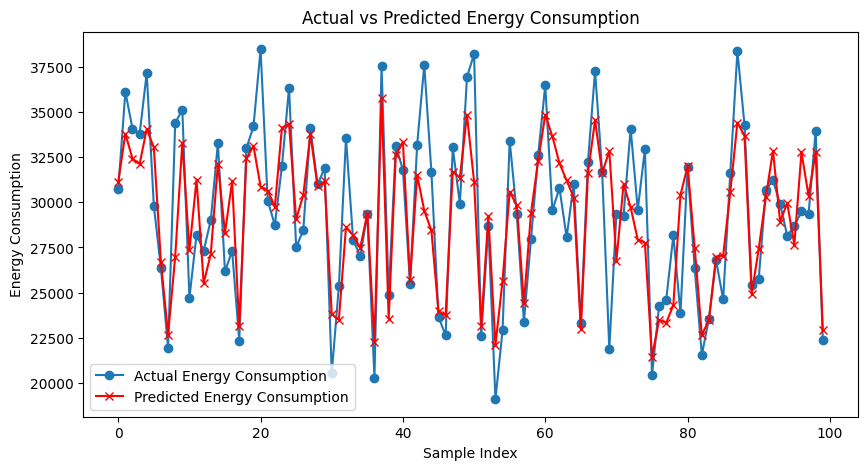

Date: 2018-12-31 22:00:00, Predicted Energy Consumption: 27374.15625
Date: 2019-01-01 22:00:00, Predicted Energy Consumption: 30136.15234375
Date: 2019-01-02 22:00:00, Predicted Energy Consumption: 30389.984375
Date: 2019-01-03 22:00:00, Predicted Energy Consumption: 29137.123046875
Date: 2019-01-04 22:00:00, Predicted Energy Consumption: 29072.400390625
Date: 2019-01-05 22:00:00, Predicted Energy Consumption: 28683.533203125
Date: 2019-01-06 22:00:00, Predicted Energy Consumption: 28595.287109375
Date: 2019-01-07 22:00:00, Predicted Energy Consumption: 29823.11328125
Date: 2019-01-08 22:00:00, Predicted Energy Consumption: 30136.15234375
Date: 2019-01-09 22:00:00, Predicted Energy Consumption: 30389.984375
Date: 2019-01-10 22:00:00, Predicted Energy Consumption: 29137.123046875
Date: 2019-01-11 22:00:00, Predicted Energy Consumption: 29072.400390625
Date: 2019-01-12 22:00:00, Predicted Energy Consumption: 28683.533203125
Date: 2019-01-13 22:00:00, Predicted Energy Consumption: 28595.2

<Figure size 1500x800 with 0 Axes>

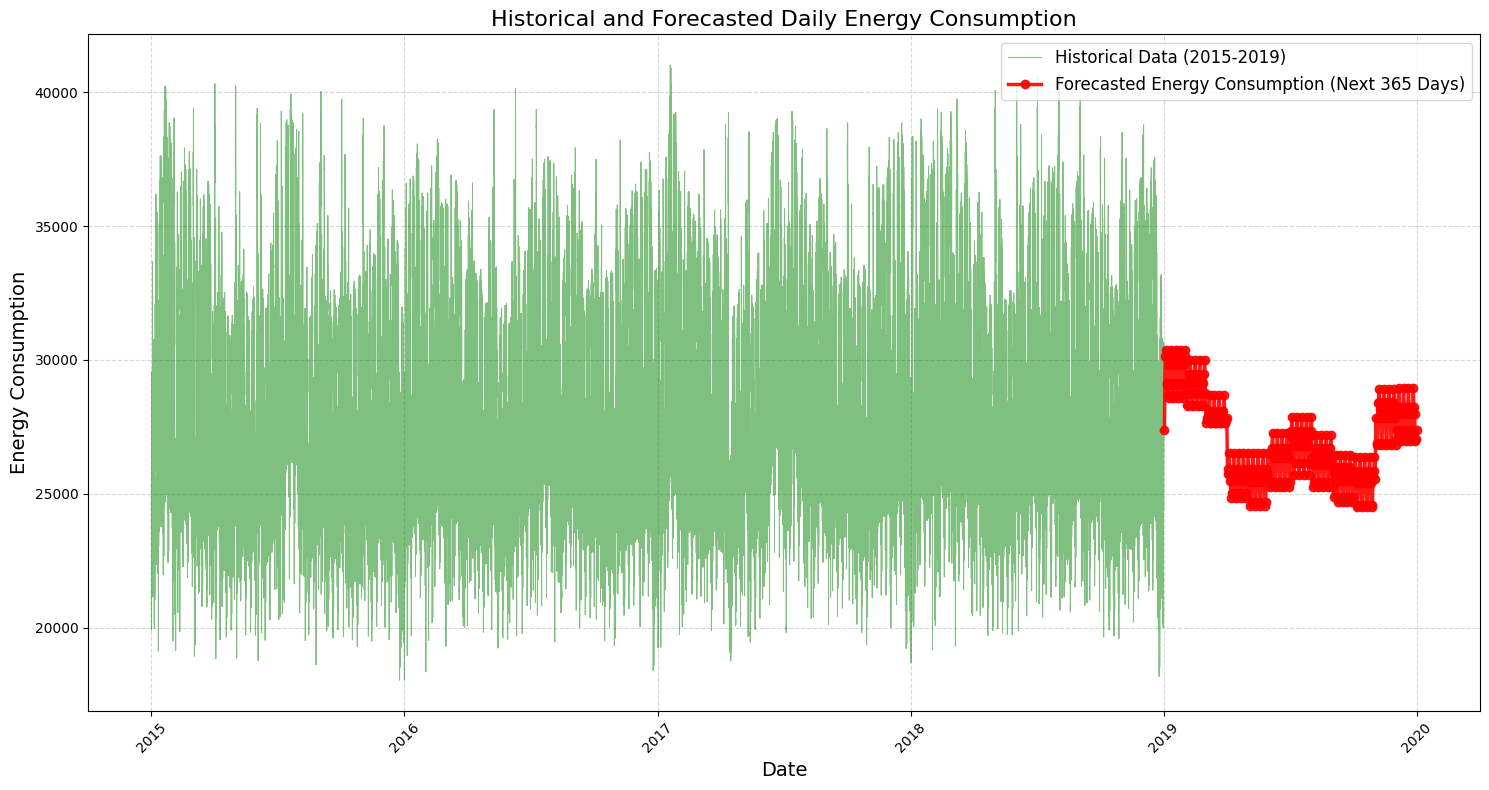

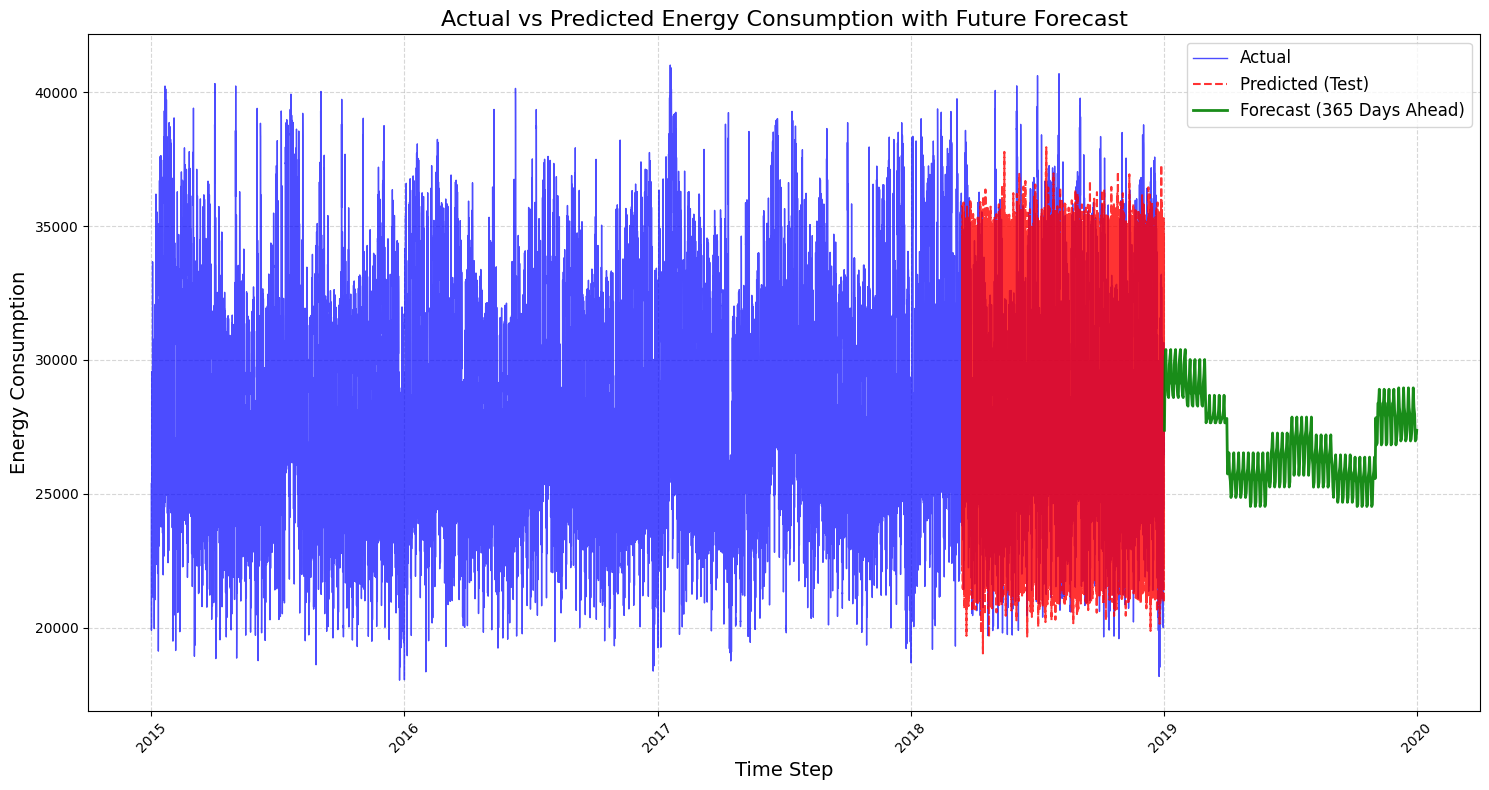

In [ ]:
# Step 9: Prepare Data for XGBOOST
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define features and target variable
features = ['temp', 'wind_speed', 'humidity', 'pressure', 'hour', 'day_of_week', 'month', 'weather_cluster','clouds_all' ]
target = 'total load actual'

# Use XGBOOST_data instead of XGBOOTS_data
X = XGBOOST_data[features]  # Changed XGBOOTS_data to XGBOOST_data
y = XGBOOST_data[target]  # Changed XGBOOTS_data to XGBOOST_data

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 10: Train the XGBOOST model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgboost_model.fit(X_train, y_train)

# Step 11: Make Predictions
y_pred = xgboost_model.predict(X_test)

# Step 12: Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'MAPE: {mape}%')

# Step 13: Plot Actual vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual Energy Consumption', marker='o')
plt.plot(y_pred[:100], label='Predicted Energy Consumption', marker='x', color='red')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.show()

# Step 14: Forecast for 365 Days
# Create future dates for 365 days
date_range = pd.date_range(start=merged_df['time'].max(), periods=365, freq='D')

# Prepare future data for prediction
future_df = pd.DataFrame()
future_df['time'] = date_range
future_df['hour'] = future_df['time'].dt.hour
future_df['day_of_week'] = future_df['time'].dt.dayofweek
future_df['month'] = future_df['time'].dt.month
future_df['year'] = future_df['time'].dt.year

# Use the most recent cluster values and weather features as placeholders
future_df['temp'] = XGBOOST_data['temp'].iloc[-1]
future_df['wind_speed'] = XGBOOST_data['wind_speed'].iloc[-1]
future_df['humidity'] = XGBOOST_data['humidity'].iloc[-1]
future_df['pressure'] = XGBOOST_data['pressure'].iloc[-1]
future_df['weather_cluster'] = XGBOOST_data['weather_cluster'].iloc[-1]
# Add this line to include 'clouds_all' in future_df
future_df['clouds_all'] = XGBOOST_data['clouds_all'].iloc[-1]

# Predict future energy consumption
future_X = future_df[features]
future_predictions = xgboost_model.predict(future_X)

# Save future predictions to Excel
future_df['predicted_energy_consumption'] = future_predictions
future_df.to_excel('future_energy_forecast.xlsx', index=False)

# Print future predictions
for date, prediction in zip(date_range, future_predictions):
    print(f'Date: {date}, Predicted Energy Consumption: {prediction}')

# Step 15: Plot Combined Data with 365 Days Forecast
plt.figure(figsize=(15, 8))
# Plot historical daily data
filtered_data = merged_df[['time', 'total load actual']].copy()
filtered_data.set_index('time', inplace=True)
daily_data = filtered_data['total load actual']

plt.figure(figsize=(15, 8))
# Plot historical daily data
plt.plot(daily_data.index, daily_data.values, linestyle='-', color='green', linewidth=0.7, alpha=0.5, label='Historical Data (2015-2019)')
# Plot future predictions
date_range_future = pd.date_range(start=daily_data.index.max() + pd.Timedelta(days=1), periods=365, freq='D')
plt.plot(date_range_future, future_predictions, color='red', linestyle='-', linewidth=2.5, marker='o', label='Forecasted Energy Consumption (Next 365 Days)', alpha=0.9)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.title('Historical and Forecasted Daily Energy Consumption', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Step 16: Plot Actual vs Predicted with Future Forecast
plt.figure(figsize=(15, 8))
# Plot actual data
plt.plot(daily_data.index, daily_data.values, color='blue', linewidth=1, label='Actual', alpha=0.7)
# Plot predicted data
plt.plot(daily_data.index[-len(y_pred):], y_pred, color='red', linestyle='--', linewidth=1.5, label='Predicted (Test)', alpha=0.8)
# Plot forecast data
plt.plot(date_range_future, future_predictions, color='green', linestyle='-', linewidth=2, label='Forecast (365 Days Ahead)', alpha=0.9)

plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.title('Actual vs Predicted Energy Consumption with Future Forecast', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()